In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

%load_ext autoreload
%autoreload 2

# How to use the state evolution package

Let's look at a simple example of how to use the state evolution package with custom teacher-student covariance rmrices. The class has three components:
- `data_model`: this class defines everything concerning the generative model for data - i.e. it initialises the covariances $\Psi, \Phi, \Omega$ and the teacher weights $\theta_{0}$ and pre-computes all the quantities required for the state evolution.
- `model`: this class defines the task. It basically contains the updates for the overlaps and their conjugates. So far, we have implemented ridge and logistic regression.
- `algorithms`: this class defines the iterator for the state evolution.

In [2]:
from state_evolution.models.logistic_regression import LogisticRegression # logistic regression task
from state_evolution.models.bayes_optimal_probit import BayesOptimalProbit
from state_evolution.algorithms.state_evolution import StateEvolution # Standard SP iteration
from state_evolution.auxiliary.utility import *

### Example 1: Custom data model: fixed sample complexity

Let's look at a simple example where we input the covariances.

In [3]:
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances

Recall that the Gaussian covariate model is defined by a teacher-student model with:
- Teacher : $y = f_{0}(\theta_{0}\cdot u)$, $\theta_{0}\sim\mathcal{N}(0,\rm{I}_{p})$
- Student : $\hat{y} = \hat{f}(w\cdot v)$
where $z\in\mathbb{R}^{p}$ and $v\in\mathbb{R}^{d}$ are jointly Gaussian variables with covariances
$$ \Psi = \mathbb{E}uu^{\top}\in\mathbb{R}^{p\times p}, \qquad \Phi = \mathbb{E}uv^{\top}\in\mathbb{R}^{p\times d}, \qquad \Omega = \mathbb{E}vv^{\top}\in\mathbb{R}^{v\times v}
$$.

The class `Custom` takes as input the three covariance matrices that define an instance of the model. 

As an example, let's look at a simple model of a Gaussian teacher $\theta_{0}\sim\mathcal{N}(0,\rm{I}_{p})$ and both the teacher and student are Random Feature models on Gaussian i.i.d. data, with different dimensions and activation functions:
$$
u = \rm{sign}\left(\frac{1}{\sqrt{D}}\bar{\rm{F}}c\right), \qquad v = \rm{erf}\left(\frac{1}{\sqrt{D}}\rm{F}c\right), \qquad c\sim\mathcal{N}(0,\rm{I}_{D})
$$

In this case recall that the covariances can be computed analytically, and are given by:

 \begin{align}
 \Psi = \bar{\kappa}_{1}^2 \bar{\rm{F}}\bar{\rm{F}}^{\top}+\bar{\kappa}_{\star}^2\rm{I}_{p}, && \Phi = \bar{\kappa}_{1}\kappa_{1} \bar{\rm{F}}\rm{F}^{\top}, && \Omega = \kappa_{1}^2 \rm{F}\rm{F}^{\top}+\kappa_{\star}^2\rm{I}_{d}
 \end{align}
 
with $\kappa_{1} \equiv \mathbb{E}\left[\xi\sigma(\xi)\right]$ and $\kappa_{\star}^2 \equiv \mathbb{E}\left[\sigma(\xi)\right]^2-\kappa_{1}^2$ for $\xi\sim\mathcal{N}(0,1)$ (idem for the bar). 

In [4]:
COEFICIENTS = {'relu': (1/np.sqrt(2*np.pi), 0.5, np.sqrt((np.pi-2)/(4*np.pi))), 
               'erf': (0, 2/np.sqrt(3*np.pi), 0.200364),
               'tanh': (0, 0.605706, 0.165576),
               'sign': (0, np.sqrt(2/np.pi), np.sqrt(1-2/np.pi))}

D = 128 # dimension of c
p = 128 # dimension of k
d = 256 # dimension of x

F_teacher = np.random.normal(0,1, (p,D)) / np.sqrt(D) # teacher random projection
F_student = np.random.normal(0,1, (d,D)) / np.sqrt(D) # student random projection

# Coefficients
_, kappa1_teacher, kappastar_teacher = COEFICIENTS['erf']
_, kappa1_student, kappastar_student = COEFICIENTS['erf']

# Covariances

Omega = (kappa1_student**2 * F_student @ F_student.T + kappastar_student**2 * np.identity(d))
Phi   = kappa1_teacher * kappa1_student * F_teacher @ F_student.T
Psi   = (kappa1_teacher**2 * F_teacher @ F_teacher.T + kappastar_teacher**2 * np.identity(p))

# Teacher weights
theta = np.random.multivariate_normal(mean=np.zeros(p), cov=np.eye(p))
# NORMALIZE THE TEACHER FOR BETTER RESULTS
theta = np.sqrt(p) * theta / np.linalg.norm(theta)

Now that we have our covariances, we can create our instance of `Custom`:

In [5]:
data_model = Custom(teacher_teacher_cov = Psi,
                    student_student_cov = Omega,
                    teacher_student_cov = Phi,
                    teacher_weights = theta)

Now, we need to load our task. Let's look at logistic regression. The `model` class takes as an input the sample complexity $\alpha = n/d$ and the $\ell_2$ regularisation $\lambda>0$

In [13]:
alpha = 0.5

task = LogisticRegression(sample_complexity = alpha,
                          regularisation= 0.01,
                          data_model = data_model,
                          Delta = 1.0)

bo_task = BayesOptimalProbit(sample_complexity = alpha,
                          data_model = data_model,
                          Delta = 1.0)

All that is left is to initialise the saddle-point equation iterator:

In [14]:
sp = StateEvolution(model = task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)

In [15]:
bo_sp = StateEvolution(model = bo_task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)

Now, we can simply iterate it

In [16]:
debut = time()
sp.iterate()
print(f'Elapsed time : {time() - debut}')

Elapsed time : 6.4636030197143555


In [17]:
debut = time()
bo_sp.iterate()
print(f'Elapsed time : {time() - debut}')

Elapsed time : 0.6712889671325684


Voila, now you can check the result with method `get_info`, which gives everything you might be interested in a dictionary.

In [18]:
print(sp.get_info())
print(bo_sp.get_info())

{'hyperparameters': {'initialisation': 'uninformed', 'damping': 0.5, 'max_steps': 1000, 'tolerance': 1e-07}, 'status': 1, 'convergence_time': 68, 'test_error': 0.46006785249794185, 'overlaps': {'variance': 18.702451857828258, 'self_overlap': 7.156038166555334, 'teacher_student': 0.3966002213672768}, 'test_loss': 1.1495935041793501, 'train_loss': 0.1277297804996524, 'calibration': 0.22934699293281557}
{'hyperparameters': {'initialisation': 'uninformed', 'damping': 0.5, 'max_steps': 1000, 'tolerance': 1e-07}, 'status': 1, 'convergence_time': 36, 'test_error': 0.43606349536271244, 'overlaps': {'variance': 0.33413029516428794, 'self_overlap': 0.055887755452640055, 'teacher_student': 0.055887755452640055}, 'test_loss': -1.0, 'train_loss': -1.0, 'calibration': 0.0}


### Example 2: Custom data model: whole learning curve

It is boring to repeat all the pipeline above every time you want to compute a new $\alpha$. Instead, we can encapsulate it in an `experiment` class which allows one to compute a whole learning curve in one go.

In [19]:
from state_evolution.experiments.learning_curve import CustomExperiment

The class `CustomExperiment` takes as argument the task you want (from those implemented), the regularisation and the data_model, apart from all the hyperparameters of the iterator.

In [20]:
erm_experiment = CustomExperiment(task = 'logistic_regression', 
                                 regularisation = 1.0, 
                                 data_model = data_model, 
                                 initialisation='uninformed', 
                                 tolerance = 1e-7, 
                                 damping = 0.5, 
                                 verbose = False, 
                                 max_steps = 1000,
                                 sigma = 0.0)

bo_experiment = CustomExperiment(task = 'bo_probit', 
                                 regularisation = None, 
                                 data_model = data_model, 
                                 initialisation='uninformed', 
                                 tolerance = 1e-7, 
                                 damping = 0.5, 
                                 verbose = False, 
                                 max_steps = 1000,
                                 sigma = 0.0)

To compute the learning curve, you need to pass a python iterable with the values of the sample complexity you want to compute

In [21]:
alpha_range = np.linspace(0.1, 1.0, 5)
bo_experiment.learning_curve(alphas = alpha_range)
erm_experiment.learning_curve(alphas = alpha_range)

In [27]:
print(bo_experiment.get_curve()[['sample_complexity', 'q']])

   sample_complexity         q
0              0.100  0.038649
1              0.325  0.106993
2              0.550  0.156382
3              0.775  0.192908
4              1.000  0.220594


The method `.get_curve()` returns the learning curve as a `pandas.DataFrame`.

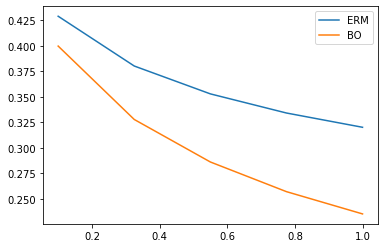

In [22]:
erm_curve = erm_experiment.get_curve()
plt.plot(erm_curve['sample_complexity'], erm_curve['test_error'], label='ERM')

bo_curve = bo_experiment.get_curve()
plt.plot(bo_curve['sample_complexity'], bo_curve['test_error'], label='BO')

plt.legend()

Note you can save it in a csv, you can just call the method `save_experiment`

In [15]:
#my_experiment.save_experiment(name='testing')

### Example 3: defining a model directly as a function of the specta

Note that even though an instance of the Gaussian covariate model is defined by $(\Psi, \Phi, \Omega, \theta_{0})$, the saddle-point equations can be closed on the following scalar quantities:
\begin{align}
\rho = \frac{1}{p}\theta_{0}^{\top}\Psi\theta_{0}, && \omega_{i}\in \rm{spec}(\Omega), && t_{i} = \left(U^{\top}\Phi^{\top}\theta_{0}\theta_{0}^{\top}\Phi U\right)_{ii}, && i=1, \cdots, d
\end{align}
where $\rm{spec}(\Omega)$ are the eigenvalues of $\Omega$ and $U\in\mathbb{R}^{d\times d}$ are the eigenvectors of $\Omega$. 

Therefore, we can also define our `data_model` by directly passing these quantities to the class `CustomSpectra`

In [6]:
from state_evolution.data_models.custom import CustomSpectra

In [7]:
print('Computing the spectrum')
spec_Omega, U = np.linalg.eigh(Omega)

print('Projection in student basis')
t = np.diagonal(U.T @ Phi.T @ theta.reshape(p, 1) @ theta.reshape(1, p) @ Phi @ U)

print('Computing rho')
rho = 1/p * theta.dot(Psi @ theta)

Computing the spectrum
Projection in student basis
Computing rho


Note that $\rho\in\mathbb{R}$, but both $\{\omega_{i}\}_{i=1}^{d}$ and $\{t_{i}\}_{i=1}^{d}$ are $d$-dimensional quantities. Therefore, we will also need to pass $\gamma = p/d$ to our `data_model` in order to run the saddle-point equations.

In [9]:
data_model_spec = CustomSpectra(rho = rho, 
                                spec_Omega = spec_Omega, 
                                diagonal_term = t,
                                gamma = p/d)

In [13]:
my_experiment = CustomExperiment(task = 'logistic_regression', 
                                 regularisation = 0.01, 
                                 data_model = data_model_spec, 
                                 initialisation='uninformed', 
                                 tolerance = 1e-7, 
                                 damping = 0.5, 
                                 verbose = True, 
                                 max_steps = 1000)

my_experiment.learning_curve(alphas = [0.5])

Runninig sample complexity: 0.5
